In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from astral import Astral, AstralGeocoder, Location

from sklearn.metrics import accuracy_score
import statsmodels.api as sm



import datetime
%matplotlib inline

In [2]:
phil_stops = pd.read_csv('data/philadelpha_stops.csv')

In [3]:
phil_stops.head()

,raw_row_number,date,time,location,lat,lng,district,service_area,subject_age,subject_race,subject_sex,type,arrest_made,outcome,contraband_found,frisk_performed,search_conducted,search_person,search_vehicle
0,1,2014-09-27,20:05:00,5600 BLOCK BROOMALL ST,39.943742,-75.232790,12.0,124.0,24.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False
1,2,2014-09-27,19:27:00,5200 BLOCK PENTRIDGE ST,39.945217,-75.224756,12.0,124.0,58.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False
2,3,2014-09-27,19:27:00,5200 BLOCK PENTRIDGE ST,39.945217,-75.224756,12.0,124.0,31.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False
3,4,2014-09-27,20:38:00,4900 BLOCK KINGSESSING AV,39.943045,-75.215211,12.0,123.0,29.0,black,male,vehicular,False,NaN,NaN,False,False,False,False
4,5,2014-10-24,03:00:00,1800 BLOCK WALNUT ST,39.950203,-75.171467,9.0,92.0,35.0,black,male,pedestrian,False,NaN,NaN,False,False,False,False


In [4]:
phil_stops.columns

Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng', 'district',
       'service_area', 'subject_age', 'subject_race', 'subject_sex', 'type',
       'arrest_made', 'outcome', 'contraband_found', 'frisk_performed',
       'search_conducted', 'search_person', 'search_vehicle'],
      dtype='object')

In [5]:
len(phil_stops)

1891916

In [6]:
phil_stops['date'] = pd.to_datetime(phil_stops['date'])

In [7]:
phil_stops['date'].min()

Timestamp('2014-01-01 00:00:00')

In [8]:
phil_stops['date'].max()

Timestamp('2018-04-14 00:00:00')

In [9]:
get_year = lambda date: date.year
phil_stops['year'] = phil_stops['date'].apply(get_year)
phil_stops = phil_stops[(phil_stops['year'] >= 2014) & (phil_stops['year'] <= 2017)]

In [10]:
(phil_stops['date'].min(), phil_stops['date'].max(), len(phil_stops))

(Timestamp('2014-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'), 1782092)

In [11]:
phil_stops['type'].head(10)

0    pedestrian
1    pedestrian
2    pedestrian
3     vehicular
4    pedestrian
5    pedestrian
6     vehicular
7    pedestrian
8    pedestrian
9     vehicular
Name: type, dtype: object

In [12]:
phil_stops = phil_stops[phil_stops['type'] == 'vehicular']
len(phil_stops)

1090441

In [13]:
phil_stops.groupby('year').size()

year
2014    219071
2015    285914
2016    288306
2017    297150
dtype: int64

In [14]:
def calc_group_size(stops_df, groupby_cols, include_prop = True):
    groupby = phil_stops.groupby(groupby_cols).size().to_frame().reset_index()
    groupby.columns = list(groupby_cols) + ['n']
    if include_prop:
        groupby['prop'] = groupby['n'] / len(stops_df)
    return groupby

In [15]:
calc_group_size(phil_stops, ['subject_race'])

,subject_race,n,prop
0,asian/pacific islander,31197,0.028610
1,black,714772,0.655489
2,hispanic,112950,0.103582
3,other/unknown,15109,0.013856
4,white,216413,0.198464


In [16]:
groupby_year_and_race = calc_group_size(phil_stops, ['year', 'subject_race'])
groupby_year_and_race

,year,subject_race,n,prop
0,2014,asian/pacific islander,7317,0.006710
1,2014,black,134192,0.123062
2,2014,hispanic,23036,0.021125
3,2014,other/unknown,2631,0.002413
4,2014,white,51895,0.047591
5,2015,asian/pacific islander,8613,0.007899
6,2015,black,183067,0.167883
7,2015,hispanic,30105,0.027608
8,2015,other/unknown,3793,0.003478
9,2015,white,60336,0.055332


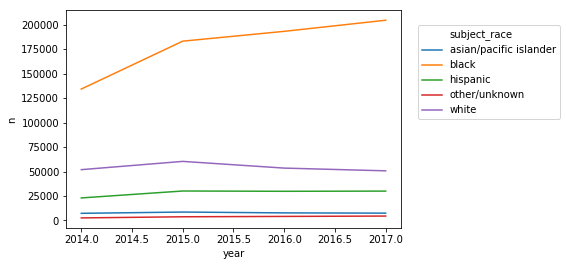

In [17]:
ax = sns.lineplot(x = 'year', y = 'n', hue = 'subject_race', data = groupby_year_and_race);
ax.legend(loc = (1.05, 0.5));

In [18]:
population_df = pd.DataFrame({'asian/pacific islander': 110864, 'black': 648846, 'hispanic': 221777, 'other/unknown': 39858,
                'white': 548312}.items())
population_df.columns = ['subject_race', 'num_people']
population_df

,subject_race,num_people
0,asian/pacific islander,110864
1,black,648846
2,hispanic,221777
3,other/unknown,39858
4,white,548312


In [19]:
phil_stops_2017 = phil_stops[phil_stops['year'] == 2017]

In [20]:
def calc_stop_rates(stops_df, population_df, groupby_cols):
    groupby_df = stops_df.groupby(groupby_cols).size().reset_index()
    groupby_df.columns = groupby_cols + ['n']
    merged = groupby_df.merge(population_df, on ='subject_race')
    merged['stop_rate'] = merged['n'] / merged['num_people']
    return merged[['subject_race', 'stop_rate']]

In [21]:
calc_stop_rates(phil_stops_2017, population_df, ['subject_race'])

,subject_race,stop_rate
0,asian/pacific islander,0.067687
1,black,0.315052
2,hispanic,0.135267
3,other/unknown,0.113628
4,white,0.092462


In [22]:
def calc_search_rates(stops_df, groupby_cols):
    groupby_df = stops_df.groupby(groupby_cols)['search_conducted'].mean().reset_index()
    groupby_df.columns = groupby_cols + ['search_rate']
    return groupby_df

In [23]:
calc_search_rates(phil_stops_2017, ['subject_race'])

,subject_race,search_rate
0,asian/pacific islander,0.026119
1,black,0.060547
2,hispanic,0.051002
3,other/unknown,0.036873
4,white,0.040968


In [24]:
def calc_frisk_rates(stops_df, groupby_cols):
    groupby_df = stops_df.groupby(groupby_cols)['frisk_performed'].mean().reset_index()
    groupby_df.columns = groupby_cols + ['frisk_rate']
    return groupby_df

In [25]:
calc_frisk_rates(phil_stops_2017, ['subject_race'])

,subject_race,frisk_rate
0,asian/pacific islander,0.018790
1,black,0.063624
2,hispanic,0.047102
3,other/unknown,0.034003
4,white,0.030593


In [26]:
def calc_hit_rates(stops_df, groupby_cols):
    groupby_df = stops_df.groupby(groupby_cols)['contraband_found'].mean().reset_index()
    groupby_df = groupby_df.dropna()
    groupby_df = groupby_df.reset_index(drop = True)
    groupby_df.columns = groupby_cols + ['hit_rate']
    return groupby_df

In [27]:
phil_stops_2017['contraband_found'] = phil_stops_2017['contraband_found'].astype(float)
calc_hit_rates(phil_stops_2017, ['subject_race'])

/anaconda3/envs/general/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,subject_race,hit_rate
0,asian/pacific islander,0.244898
1,black,0.219520
2,hispanic,0.200654
3,other/unknown,0.173653
4,white,0.247472


In [28]:
hit_rates = calc_hit_rates(phil_stops_2017, groupby_cols = ['subject_race', 'district'])
hit_rates.head()

,subject_race,district,hit_rate
0,asian/pacific islander,1.0,0.166667
1,asian/pacific islander,2.0,0.500000
2,asian/pacific islander,3.0,0.400000
3,asian/pacific islander,6.0,0.333333
4,asian/pacific islander,7.0,0.000000


In [29]:
def compare_hit_rates(hit_rates, minority_races, index_cols):
    hit_rates = hit_rates[hit_rates['subject_race'].isin(['white'] + minority_races)]
    hit_rates = hit_rates.set_index(list(index_cols) + ['subject_race'])['hit_rate'].unstack(fill_value = 0)
    hit_rates = hit_rates.rename(columns = {'white': 'white_hit_rate'}).reset_index()
    hit_rates = hit_rates.melt(id_vars = list(index_cols) + ['white_hit_rate'])
    hit_rates = hit_rates.rename(columns = {'subject_race': 'minority_race', 'value': 'minority_hit_rate'})
    hit_rates = hit_rates.sort_values(by = 'district')
    return hit_rates.reset_index(drop = True)

def plot_hit_rates_comparison(hit_rates_comparison, marker_size_col, marker_size_scale = 500):
    g = sns.FacetGrid(hit_rates_comparison, col="minority_race", height = 5)
    g.map(plt.grid)
    g.map_dataframe(plt.plot, [0, 1], [0,1], 'r--', color = 'black')
    if marker_size_col is not None:
        g.map(plt.scatter, "white_hit_rate", "minority_hit_rate", color = 'black', facecolors = 'none', 
                            s = hit_rates_comparison[marker_size_col] / marker_size_scale).set(
                            xlim=(-0.05,1.05) , ylim=(-0.05,1.05), xlabel = 'White hit rate', ylabel = 'Minority hit rate')
    else:
        g.map(plt.scatter, "white_hit_rate", "minority_hit_rate", color = 'black').set(
                            xlim=(-0.05,1.05) , ylim=(-0.05,1.05), xlabel = 'White hit rate', ylabel = 'Minority hit rate')
    g.add_legend();

In [30]:
hit_rates_comparison = compare_hit_rates(hit_rates, ['black', 'hispanic'], ['district'])
hit_rates_comparison.head()

,district,white_hit_rate,minority_race,minority_hit_rate
0,1.0,0.611111,black,0.185841
1,1.0,0.611111,hispanic,0.500000
2,2.0,0.363636,black,0.343915
3,2.0,0.363636,hispanic,0.246914
4,3.0,0.413333,black,0.250000


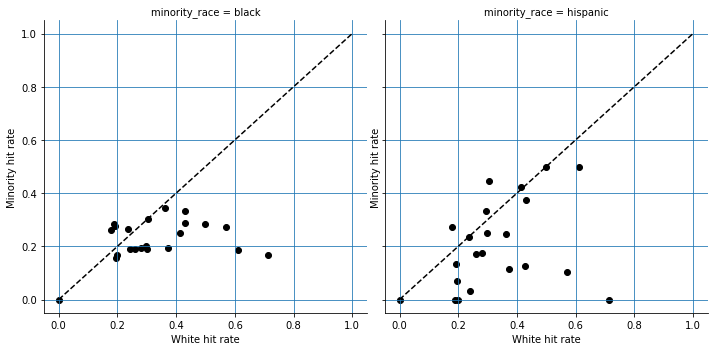

In [31]:
plot_hit_rates_comparison(hit_rates_comparison, None)

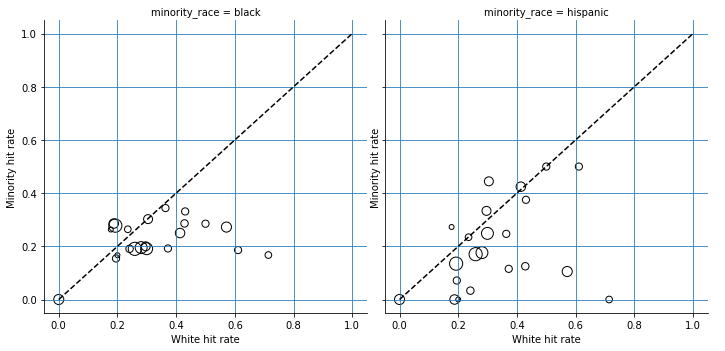

In [32]:
hit_rates_comparison_with_size = hit_rates_comparison.merge(calc_group_size(phil_stops, ['district'], False))
plot_hit_rates_comparison(hit_rates_comparison_with_size, 'n')

In [45]:
def calc_sunset_times(stops_df, latitude, longitude, timezone):
    l = Location()
    l.solar_depression = 'civil'
    l.latitude = latitude
    l.longitude = longitude
    l.timezone = timezone
    l.elevation = 0   
    unique_dates = list(stops_df['date'].unique())
    sunset = [l.sun(pd.Timestamp(date), local = True)['sunset'].time() for date in unique_dates]
    dusk = [l.sun(pd.Timestamp(date), local = True)['dusk'].time() for date in unique_dates]
    sunset_minutes = [time.hour * 60 + time.minute for time in sunset]
    dusk_minutes = [time.hour * 60 + time.minute for time in dusk]
    sunset_times = pd.DataFrame(zip(unique_dates, sunset, dusk, sunset_minutes, dusk_minutes))
    sunset_times.columns = ['date', 'sunset', 'dusk', 'sunset_minute', 'dusk_minute']
    return sunset_times


In [52]:
sunset_times_2017 = calc_sunset_times(phil_stops_2017, 39.9525839, -75.1652215, 'US/Eastern')
sunset_times_2017[(sunset_times_2017['sunset'] == sunset_times_2017['sunset'].min()) | (sunset_times_2017['sunset'] == sunset_times_2017['sunset'].max())]

,date,sunset,dusk,sunset_minute,dusk_minute
145,2017-06-28,20:33:27,21:06:12,1233,1266
218,2017-12-08,16:35:22,17:05:39,995,1025


In [138]:
def get_veil_of_darkness_observations(stops_df, sunset_times):
    stops_df = stops_df.copy()
    merged = stops_df.merge(sunset_times, on = 'date')
    times = merged['time'].apply(lambda time: datetime.datetime.strptime(time, '%H:%M:%S').time())
    merged['minute'] = times.apply(lambda time: time.hour * 60 + time.minute)
    merged['minutes_after_dark'] = merged['minute'] - merged['dusk_minute']
    merged['is_dark'] = (merged['minute'] > merged['dusk_minute']).astype(int)
    min_dusk_minute = merged['dusk_minute'].min()
    max_dusk_minute = merged['dusk_minute'].max()
    # Filter to get only the intertwilight period
    merged = merged[(merged['minute'] > min_dusk_minute) & (merged['minute'] < max_dusk_minute)] 
    # Remove ambigous period between sunset and dusk
    merged = merged[~((merged['minute'] > merged['sunset_minute']) &\
                        (merged['minute'] < merged['dusk_minute']))]
    return merged

In [139]:
vod_stops = get_veil_of_darkness_observations(phil_stops_2017, sunset_times_2017)

In [140]:
vod_stops.head()

,raw_row_number,date,time,location,lat,lng,district,service_area,subject_age,subject_race,...,search_person,search_vehicle,year,sunset,dusk,sunset_minute,dusk_minute,minute,minutes_after_dark,is_dark
0,1025649,2017-03-22,20:30:00,NaN,NaN,NaN,25.0,252.0,39.0,white,...,False,False,2017,19:14:01,19:41:02,1154,1181,1230,49,1
2,1025656,2017-03-22,19:50:00,NaN,NaN,NaN,25.0,252.0,42.0,black,...,False,False,2017,19:14:01,19:41:02,1154,1181,1190,9,1
3,1025657,2017-03-22,21:05:00,NaN,NaN,NaN,25.0,251.0,81.0,white,...,False,False,2017,19:14:01,19:41:02,1154,1181,1265,84,1
5,1025668,2017-03-22,20:05:00,NaN,NaN,NaN,25.0,253.0,24.0,black,...,False,False,2017,19:14:01,19:41:02,1154,1181,1205,24,1
10,1037653,2017-03-22,18:40:00,100 BLOCK S 60TH ST,39.960437,-75.241136,18.0,181.0,28.0,black,...,False,False,2017,19:14:01,19:41:02,1154,1181,1120,-61,0


In [141]:
vod_stops[(vod_stops['subject_race'] == 'white') | (vod_stops['subject_race'] == 'black')].shape

(80334, 27)

In [143]:
def calc_vod_rate_of_minority(vod_stops, start_time, end_time, minority_race):
    vod_stops = vod_stops.copy()
    vod_stops = vod_stops[(vod_stops['time'] > start_time) & (vod_stops['time'] < end_time)]
#     vod_stops = vod_stops[vod_stops['subject_race'].isin(['white', minority_race])]
    vod_stops['is_{}'.format(minority_race)] = (vod_stops['subject_race'] == minority_race).astype(int)
    groupby = vod_stops.groupby(['is_dark'])['is_{}'.format(minority_race)].mean()
    return groupby


In [144]:
calc_vod_rate_of_minority(vod_stops, '18:30', '18:45', 'black')

is_dark
0    0.693128
1    0.644799
Name: is_black, dtype: float64

In [159]:
is_black = (vod_stops['subject_race'] == 'black').astype(int)
X = vod_stops[['is_dark', 'minute']]
X = sm.add_constant(X)
# X
logit_model = sm.GLM(is_black, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                95094
Model:                            GLM   Df Residuals:                    95091
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -58425.
Date:                Thu, 11 Apr 2019   Deviance:                   1.1685e+05
Time:                        10:09:43   Pearson chi2:                 9.51e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3475      0.138     -9.742      0.000      -1.619      -1.076
is_dark       -0.1822      0.017    -11.039      0.0

/anaconda3/envs/general/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [160]:
accuracy_score(is_black.values, (logit_results.predict(X) > 0.5).astype(int).values)

0.6940921614402591

In [161]:
X = vod_stops[['is_dark', 'minute']]
X = X.merge(pd.get_dummies(vod_stops['district']), left_index = True, right_index = True)
X = sm.add_constant(X)
# X
logit_model = sm.GLM(is_black, X, family=sm.families.Binomial())
logit_results = logit_model.fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           subject_race   No. Observations:                95094
Model:                            GLM   Df Residuals:                    95070
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43426.
Date:                Thu, 11 Apr 2019   Deviance:                       86853.
Time:                        10:09:47   Pearson chi2:                 9.51e+04
No. Iterations:                     5   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7040      0.161     -4.376      0.000      -1.019      -0.389
is_dark       -0.1547      0.020     -7.769      0.0

In [162]:
accuracy_score(is_black.values, (logit_results.predict(X) > 0.5).astype(int).values)

0.7918480661240457

In [38]:
# from pytz import all_timezones
# for timezone in all_timezones:
# #     print(timezone)